# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [91]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [92]:
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date',parse_dates=True)
#display(train_df.info())
#display(train_df.head(5))
train_df.shape

(14149, 86)

In [93]:
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date',parse_dates=True)
#display(test_df.info())
#display(test_df.head(5))
test_df.shape

(5290, 52)

In [94]:
full_df =pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date',parse_dates=True)
#display(full_df.info())
#display(full_df.head())
full_df.shape

(19439, 86)

Вывод: данные записаны в верном формате. есть пропуски в данных.

### Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [95]:
def recovery(row):
    """эффективность обогащения"""
    reco = (row['rougher.output.concentrate_au']*(row['rougher.input.feed_au']-row['rougher.output.tail_au']) ) / (
        row['rougher.input.feed_au']*(row['rougher.output.concentrate_au']-row['rougher.output.tail_au']) * 0.01)
    return reco
       

In [96]:
train_df['recovery'] = train_df.apply(recovery, axis=1)
train_df['recovery'].mean()

82.70450164550293

In [97]:
mean_absolute_error(train_df['rougher.output.recovery'], train_df['recovery'])

1.1159322498192853e-14

Вывод: эффективность обогащения рассчитана правильно. MAE между расчётами и значением признака не большое.

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

### Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [99]:
a = []
for i in train_df.columns:
    if i not in test_df.columns:
        a.append(i)

a

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке не хватает данных:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Тип данных float64

### Проведите предобработку данных.


In [100]:
# так как данные связаны между собой, использую метод interpolate для заполнения пропусков средним из соседних значений.
train_df = train_df.interpolate()
test_df = test_df.interpolate()
full_df = full_df.interpolate()
#test_df.info()
#train_df

In [101]:
#  добавил недостающие столбцы в тестовую выборку
full_df_merged = full_df[["rougher.output.recovery", "final.output.recovery"]]
test_df = test_df.merge(full_df_merged, on="date", how="left")

In [102]:
test_df.shape

(5290, 54)

Вывод: Заполнил пропуски средним между соседними значениями, добавил недостающие столбцы в тестовую выборку

### Вывод

Загрузил данные для исследования. Проверил, что эффективность обогащения рассчитана правильно. Нашел признаки недоступные в тестовой выборке. Заполнил пропуски средним между соседними значениями.

## Анализ данных

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [103]:
def hist_metall(final, primary, rougher, raw, name):
    plt.hist(final, bins=100, alpha=0.5, label='Final')
    plt.hist(primary, bins=100, alpha=0.5, label='Primary cleaner')
    plt.hist(rougher, bins=100, alpha=0.5, label='Rougher')
    plt.hist(raw, bins=100, alpha=0.5, label='Raw')
    plt.title(name)
    plt.legend()
    plt.show()

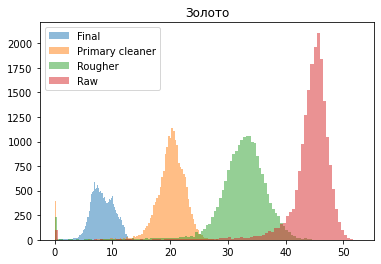

In [104]:
hist_metall(full_df['rougher.input.feed_au'],
           full_df['rougher.output.concentrate_au'],
           full_df['primary_cleaner.output.concentrate_au'],
           full_df['final.output.concentrate_au'],
           'Золото')

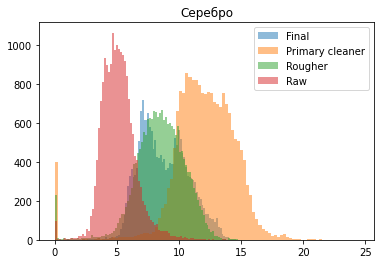

In [105]:
hist_metall(full_df['rougher.input.feed_ag'],
           full_df['rougher.output.concentrate_ag'],
           full_df['primary_cleaner.output.concentrate_ag'],
           full_df['final.output.concentrate_ag'],
           'Серебро')

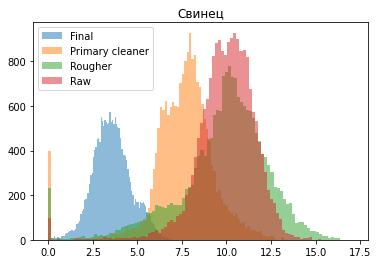

In [106]:
hist_metall(full_df['rougher.input.feed_pb'],
           full_df['rougher.output.concentrate_pb'],
           full_df['primary_cleaner.output.concentrate_pb'],
           full_df['final.output.concentrate_pb'],
           'Свинец')

Вывод: Меньше всего после этапов очистки остается золота. С каждым этапом очистки, концентрация уменьшается.

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [107]:
train_df['primary_cleaner.input.feed_size'].mean()

7.322309906901314

In [108]:
test_df['primary_cleaner.input.feed_size'].mean()

7.266339191270906

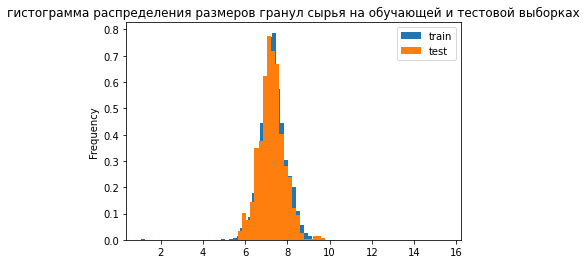

In [109]:
train_df['primary_cleaner.input.feed_size'].plot(kind='hist', bins=50, density=True, label='train')
test_df['primary_cleaner.input.feed_size'].plot(kind='hist', bins=50, density=True, label='test')

plt.legend(loc='upper right')
plt.title('гистограмма распределения размеров гранул сырья на обучающей и тестовой выборках')
plt.show()

Вывод: Распределения размеров гранул сырья на обучающей и тестовой выборках практически не отличается.

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [110]:
features_rough_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]

features_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]
features_final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
]

display(test_df.shape)
display(train_df.shape)

train_df = train_df[train_df[features_input_concentrate].sum(1) > 0]
train_df = train_df[train_df[features_rough_concentrate].sum(1) > 0]
train_df = train_df[train_df[features_final_concentrate].sum(1) > 0]

full_df = full_df.loc[test_df.index]
test_df = test_df[full_df[features_input_concentrate].sum(1) > 0]
test_df = test_df[full_df[features_rough_concentrate].sum(1) > 0]
test_df = test_df[full_df[features_final_concentrate].sum(1) > 0]
display(test_df.shape)
display(train_df.shape)

(5290, 54)

(14149, 87)

/tmp/ipykernel_37/4233236035.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = test_df[full_df[features_final_concentrate].sum(1) > 0]


(5154, 54)

(13795, 87)

Вывод: все нулевые значения на всех этапах удалил из выборок.

## Модель

### Напишите функцию для вычисления итоговой sMAPE.

In [111]:
def calculate_smape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return 1 / len(target_actual) * np.sum(numerator / denominator) * 100 
  
def calculate_final_smape(target_actual, target_predictions):
    target_actual_rougher = target_actual['rougher.output.recovery']
    target_actual_final = target_actual['final.output.recovery']
    target_predictions_rougher = target_predictions[:, 0]
    target_predictions_final = target_predictions[:, 1]
    return 0.25 * calculate_smape(target_actual_rougher, target_predictions_rougher) + 0.75 * calculate_smape(target_actual_rougher, target_predictions_rougher)

smape_scorer = make_scorer(calculate_final_smape, greater_is_better=False)


Вывод: написал функцию для вычисления итоговой sMAPE

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [112]:
# удалил столбец recovery из обучающей выборки, подсчитанный ранее.
train_df = train_df.drop("recovery", axis=1)

In [113]:
# в трейн выборке взял столбцы как и в тестовой
train_df = train_df[test_df.columns]

In [114]:
features_train = train_df.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_train = train_df[["rougher.output.recovery", "final.output.recovery"]]

features_test = test_df.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_test = test_df[["rougher.output.recovery", "final.output.recovery"]]

In [115]:
model = LinearRegression()
scores = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer)
final_score = scores.mean()
print(f'Средняя оценка качества модели: {final_score}')

Средняя оценка качества модели: -7.2338152959280135


In [116]:
param_grid = {'max_depth': range(1, 100, 10)}
model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Лучшее значение smape для дерева решений: {search.best_score_} при значениях гиперпараметров: {search.best_params_}')

Лучшее значение smape для дерева решений: -7.0494106334199245 при значениях гиперпараметров: {'max_depth': 1}


Лучший показатель у модели DecisionTreeRegressor(), ее и буду проверять на тестововй выборке

In [117]:
model = DecisionTreeRegressor(random_state=12345, max_depth=1)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
calculate_final_smape(target_test, predicted_valid)

4.778059208506637

## Общий вывод

Загрузил и проанализировал данные. Заполнил пропуски средним между соседними значениями и добавил недостающие столбцы в тестовую выборку.

Проверил как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. С каждым этапом очистки, концентрация уменьшается. Распределения размеров гранул сырья на обучающей и тестовой выборках практически не отличается.

Суммарную концентрацию всех веществ на разных стадиях равную нулю, удалил.

Написал функцию для вычисления итоговой sMAPE. Обучил разные модели и оценил их качество кросс-валидацией. Лучший показатель у модели DecisionTreeRegressor(), sMAPE = -7.04. Проверил на тестовой выборке, sMAPE = 4.77.